In [1]:
%pylab inline
import pandas as pd
import math 

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Populating the interactive namespace from numpy and matplotlib


# Constants

In [2]:
# Earnings report column names - note added 'Year' column
FEATURES = ['Name', 'Department', 'Title', 'Regular', 'Retroactive', 'Other', 'Overtime', 'Injured', 'Detail', 
            'EducationIncentive', 'TotalEarnings', 'ZIPCode', 'Year']

SELECTED_NUMERIC_FEATURES = ['Regular', 'Retroactive', 'Other', 'Overtime', 'Injured', 'Detail', 'EducationIncentive', 
                             'Year', 'MedianIncome', 'pctAsian', 'pctBlack', 'pctWhite', 'pctHispanic', 'pctMultipleRaces', 'pctOther']

# ZIPCode dataset features
ZIP_FEATURES = ['ZIPCode', 'Year', 'MedianIncome', 'pctAsian', 'pctBlack', 'pctWhite', 'pctHispanic', 'pctMultipleRaces', 'pctOther']

# Years must match the order of the file urls in ALLFILEURLS and ALLFILEPATHS
YEARS = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

# For plotting - excludes yellow since it may be hard to see in some displays
COLORS = ["black", "red", "green", "blue", "magenta", "orange", "gray", "cyan", "brown", "purple", "olive"]

'''
Constants initialized as part of data load and preprocessing

REPORTS:  an array of dataframes, with each dataframe corresponding to an earnings report from a specific year.
          ex. REPORTS[0] = 2011 earnings report; REPORTS[8] = 2019 earnings report
          
CUMULATIVE_REPORT:  a dataframe that contains all of the earning report data fromm 2011-2019          
''' 

'\nConstants initialized as part of data load and preprocessing\n\nREPORTS:  an array of dataframes, with each dataframe corresponding to an earnings report from a specific year.\n          ex. REPORTS[0] = 2011 earnings report; REPORTS[8] = 2019 earnings report\n          \nCUMULATIVE_REPORT:  a dataframe that contains all of the earning report data fromm 2011-2019          \n'

## Income level related - See dictionaries below

In [3]:
# Note:  If modifying TARGETS, modify TARGETS_DICT and array assignments in addIncomeCategoryCols(..)
TARGET_COLS = ["GeneralIncomeCat", "BostonIncomeCat"]

# Income levels: [Cutoff_0[lowerBound, upperBound], Cutoff_1[lowerBound, upperBound]]
# increments by 40k
GENERAL_INCOME_INTERVALS = [pd.Interval(left=0, right=40000),
       pd.Interval(left=40000, right=80000, closed = 'left'),
       pd.Interval(left=80000, right=120000, closed = 'left'),
       pd.Interval(left=120000, right=160000, closed = 'left'),
       pd.Interval(left=160000, right=200000, closed = 'left'),
       pd.Interval(left=200000, right=240000, closed = 'left'),
       pd.Interval(left=240000, right=280000, closed = 'left'),
       pd.Interval(left=280000, right=320000, closed = 'left'),
       pd.Interval(left=320000, right=360000, closed = 'left'),
       pd.Interval(left=360000, right=400000, closed = 'left'),
       pd.Interval(left=400000, right=math.inf, closed = 'left'),
      ]

GENERAL_INCOME_TARGETS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

LEGEND_GENERAL_INCOME = ["<40k", 
                         "40k - <80k",
                         "80k - <120k",
                         "120k - <160k",
                         "160k - <200k",
                         "200k - <240k",
                         "240k - <280k",
                         "280k - <320k",
                         "320k - <360k",
                         "360k - <400k",
                         "400k+"
                        ]

# https://datausa.io/profile/geo/boston-ma/#economy
BOSTON_INCOME_INTERVALS = [pd.Interval(left=0, right=10800, closed = 'left'),
          pd.Interval(left=10800, right=38300, closed = 'left'),
          pd.Interval(left=38300, right=62200, closed = 'left'),
          pd.Interval(left=62200, right=89900, closed = 'left'),
          pd.Interval(left=89900, right=130000, closed = 'left'),
          pd.Interval(left=130000, right=250000, closed = 'left'),
          pd.Interval(left=250000, right=math.inf, closed = 'left'),
         ]

BOSTON_INCOME_TARGETS = [0, 1, 2, 3, 4, 5, 6]

LEGEND_BOSTON_INCOME = ["<10.8k", 
                         "10.8k - <38.3k",
                         "38.3k - <62.2k",
                         "62.2k - <89.9k",
                         "89.9k - <130k",
                         "130k - <250k",
                         "250k+"
                        ]

## Dictionaries to safeguard against argument errors

In [4]:
TARGET_COLS_DICT = {"GENERAL": TARGET_COLS[0],
                    "BOSTON": TARGET_COLS[1]               
                   }

INCOME_INTERVALS_DICT = {"GENERAL": GENERAL_INCOME_INTERVALS,
                         "BOSTON": BOSTON_INCOME_INTERVALS
                        }

INCOME_TARGETS_DICT = {"GENERAL": GENERAL_INCOME_TARGETS,
                       "BOSTON": BOSTON_INCOME_TARGETS
                      }

LEGEND_DICT = {"GENERAL": LEGEND_GENERAL_INCOME,
               "BOSTON": LEGEND_BOSTON_INCOME
              }

## Data download related

In [5]:
'''
Annual socioeconomic data by ZIPCode
'''
CSV_ZIP_SOCIO = 'zip_stats_annual.csv'

'''
Constants for local folder variant of dataload
'''

# File paths
CSV2011 = 'reports/eer-2011.csv'
CSV2012 = 'reports/eer-2012.csv'
CSV2013 = 'reports/eer-2013.csv'
CSV2014 = 'reports/eer-2014.csv'
CSV2015 = 'reports/eer-2015.csv'
CSV2016 = 'reports/eer-2016.csv'
CSV2017 = 'reports/eer-2017.csv'
CSV2018 = 'reports/eer-2018.csv'
CSV2019 = 'reports/eer-2019.csv'

# File paths must match the order of the years in YEARS
ALLFILEPATHS = [CSV2011, CSV2012, CSV2013, CSV2014, CSV2015, CSV2016, CSV2017, CSV2018, CSV2019]

In [6]:
'''
Constants for web variant of dataload
'''
# URLs to earnings report datasets on Analyze Boston's website
FILEURL2011 = 'https://data.boston.gov/dataset/418983dc-7cae-42bb-88e4-d56f5adcf869/resource/a861eff8-facc-4372-9b2d-262c2887b19e/download/employee-earnings-report-2011.csv'
FILEURL2012 = 'https://data.boston.gov/dataset/418983dc-7cae-42bb-88e4-d56f5adcf869/resource/d96dd8ad-9396-484a-87af-4d15e9e2ccb2/download/employee-earnings-report-2012.csv'
FILEURL2013 = 'https://data.boston.gov/dataset/418983dc-7cae-42bb-88e4-d56f5adcf869/resource/fac6a421-72fb-4f85-b4ac-4aca1e32d94e/download/employee-earnings-report-2013.csv'
FILEURL2014 = 'https://data.boston.gov/dataset/418983dc-7cae-42bb-88e4-d56f5adcf869/resource/941c9de4-fb91-41bb-ad5a-43a35f5dc80f/download/employee-earnings-report-2014.csv'
FILEURL2015 = 'https://data.boston.gov/dataset/418983dc-7cae-42bb-88e4-d56f5adcf869/resource/2ff6343f-850d-46e7-98d1-aca79b619fd6/download/employee-earnings-report-2015.csv'
FILEURL2016 = 'https://data.boston.gov/dataset/418983dc-7cae-42bb-88e4-d56f5adcf869/resource/8368bd3d-3633-4927-8355-2a2f9811ab4f/download/employee-earnings-report-2016.csv'
FILEURL2017 = 'https://data.boston.gov/dataset/418983dc-7cae-42bb-88e4-d56f5adcf869/resource/70129b87-bd4e-49bb-aa09-77644da73503/download/employee-earnings-report-2017.csv'
FILEURL2018 = 'https://data.boston.gov/dataset/418983dc-7cae-42bb-88e4-d56f5adcf869/resource/31358fd1-849a-48e0-8285-e813f6efbdf1/download/employeeearningscy18full.csv'
FILEURL2019 = 'https://data.boston.gov/dataset/418983dc-7cae-42bb-88e4-d56f5adcf869/resource/3bdfe6dc-3a81-49ce-accc-22161e2f7e74/download/allemployeescy2019_feb19_20final-all.csv'

# File urls must match the order of the years in YEARS
ALLFILEURLS = [FILEURL2011, FILEURL2012, FILEURL2013, FILEURL2014, FILEURL2015, FILEURL2016, FILEURL2017, 
               FILEURL2018, FILEURL2019]

## Functions to load and preprocess data

In [7]:
'''
Name:     loadReports
Param:    string indicating web download (optional)
Return:   an array of employee earnings reports sourced from Analyze Boston
Does:     creates a DataFrame for every file url stored in ALLFILEURLS, storing them in an array
'''
def loadReports(location = ''):
    
    if (location == 'web'):
        source = ALLFILEURLS
    else:
        source = ALLFILEPATHS
        
    reports = []
    for i in range(len(source)):
        try:
            report = pd.read_csv(source[i], names = FEATURES, header=None).iloc[1:]
        except (UnicodeDecodeError):
            report = pd.read_csv(source[i], names = FEATURES, header=None, encoding='latin-1').iloc[1:]
            
        # Populate 'Year' column (added) with corresponding year    
        report['Year'] = YEARS[i]
        
        # For 2017, the Zip Code was not loading with a leading zero; this fixes that
        if YEARS[i] == 2017:
            report['ZIPCode'] = '0' + report['ZIPCode'].astype(str)
            
        reports.append(report)
        
    return reports

def loadZipData():
    
    try:
        report = pd.read_csv(CSV_ZIP_SOCIO, names = ZIP_FEATURES, header=None).iloc[1:]
    except (UnicodeDecodeError):
        report = pd.read_csv(CSV_ZIP_SOCIO, names = ZIP_FEATURES, header=None, encoding='latin-1').iloc[1:]
        
    return report  

In [8]:
'''
Name:     preprocessData
Param:    an array of DataFrames created from Analyze Boston's earnings reports
Return:   none
Does:     modifies a given array in order to 1) replace NaN or dashes with zeroes, 2) standardize ZIPCodes,
          3) remove entries that repeat table headings, or do not have regular pay or ZIPCode data, and 
          4) convert string pay data into floats
'''
def preprocessData(reports):
    
    for i in range(len(reports)):
        
        # Replace NaN and dash entries with 0
        reports[i] = reports[i].fillna(0)
        reports[i] = reports[i].replace('  -   ', 0)

        # Standardize ZIPCodes, removing rows that repeat the table's headings (P for Postal)
        reports[i] = reports[i][reports[i].ZIPCode.str[0] != 'P']
        reports[i]['ZIPCode'] = reports[i]['ZIPCode'].str.slice(stop=5)

        # Convert pay data to float, removing dollar signs and parentheses
        reports[i][reports[i].columns[3:11]] = reports[i][reports[i].columns[3:11]].replace('[\$,\(,\),]', '', 
                                                                                            regex=True).astype(float)
        
        # Remove entries if employee didn't receive any regular pay or if their ZIP wasn't recorded
        reports[i] = reports[i][reports[i]['ZIPCode'].notna()]
        reports[i] = reports[i][~reports[i].ZIPCode.str.contains("U")]
        reports[i] = reports[i][~reports[i].ZIPCode.str.contains("H")]
        reports[i] = reports[i][~reports[i].ZIPCode.str.contains("K")]
        reports[i] = reports[i][reports[i].Regular != 0].reset_index(drop=True)
        
        
'''
Name:     getCumulativeReport
Param:    an array of DataFrames created from Analyze Boston's earnings reports
Return:   a single DataFrame that contains data from every DataFrame in the given array
Does:     creates a cumulative DataFrame by stacking the DataFrames in the given array and reseting their indices
'''
def getCumulativeReport(reports):
    
    # Stack the DataFrames to get combined DataFrame
    cumulativeReport = pd.DataFrame()

    for i in range(len(reports)):
        cumulativeReport = pd.concat([cumulativeReport, reports[i]], axis=0)

    return cumulativeReport.reset_index(drop=True)


'''
Name:     dropColumns
Param:    a single dataframe and an array of column name
Return:   a new dataframe that is a copy of the given dataframe, with the exclusion of
            the specified columns; defaults to excluding columns with String data
'''    
def dropColumns(df, columnNames=["Name", "Department", "Title"]):
    newDF = df.copy()
    newDF = newDF.drop(columnNames, axis=1)
    return newDF.reset_index(drop=True)


'''
Name:     dropCanadianZIPCodes
Param:    a single dataframe
Returns:  the dataframe with Canadian ZIPs excluded 
'''    
def dropCanadianZIPCodes(df):
    newDF = df.copy()
    newDF = newDF[~newDF.ZIPCode.str.contains("H")]
    newDF = newDF[~newDF.ZIPCode.str.contains("K")]
    return newDF


'''
Name:     addIncomeCategoryCols
Param:    a dataframe that has a column for income and the name of that column (optional);
            if no name is given, the dataframe should have a column named "TotalEarnings"
Returns:  a new dataframe with general and boston-specific income interval categories attached
Does:     checks the income value of each instance and assigns a General and Boston
            interval category
'''
def addIncomeCategoryCols(df, earningsColName="TotalEarnings"):
    
    earningsCol = df[earningsColName]
    
    gen = []
    bos = []
    
    for i in range(len(earningsCol)):
        
        # default values for later error checking
        gen_group = -1
        bos_group = -1
        
        for j in range(len(GENERAL_INCOME_INTERVALS)):
            if (earningsCol[i] in GENERAL_INCOME_INTERVALS[j]):
                gen_group = j
                break
        for k in range(len(BOSTON_INCOME_INTERVALS)):
            if (earningsCol[i] in BOSTON_INCOME_INTERVALS[k]):
                bos_group = k
                break
        
        gen.append(gen_group)
        bos.append(bos_group)
        
    # Concatenate columns to new dataframe
    temp = df.assign(GeneralIncomeCat = gen) 
    newDF = temp.assign(BostonIncomeCat = bos) 
    
    return newDF
 

# 1. Load and preprocess dataset

In [9]:
REPORTS = loadReports()
preprocessData(REPORTS)
cumulativeReport_temp = getCumulativeReport(REPORTS)

In [10]:
cumulativeReport_temp

,Name,Department,Title,Regular,Retroactive,Other,Overtime,Injured,Detail,EducationIncentive,TotalEarnings,ZIPCode,Year
0,"Abadi,Kidani A",Assessing Department,Property Officer (Asn),33065.38,0.0,0.00,379.49,0.0,0.0,0.0,33444.87,02118,2011
1,"Ablon,Jordan N",ASD Office Of Labor Relation,Asst Corp Counsel III,76051.24,0.0,1321.03,0.00,0.0,0.0,0.0,77372.27,02135,2011
2,"Accardi,Patricia",Transportation-Parking Clerk,Chief Claims Investigator,56430.79,0.0,0.00,418.58,0.0,0.0,0.0,56849.37,02081,2011
3,"Ackerly,Lyn E.",Boston Public Library,Spec Library Asst I,35058.78,0.0,0.00,439.19,0.0,0.0,0.0,35497.97,02118,2011
4,"Adams,Carey L.",Law Department,Prin Clerk,41588.83,0.0,0.00,0.00,0.0,0.0,0.0,41588.83,02131,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...
191224,"Bruce,Charlika",BPS Transportation,Cab Monitor,60.00,0.0,0.00,0.00,0.0,0.0,0.0,60.00,02121,2019
191225,"Carter,Charlene Lois",BPS Transportation,Cab Monitor,60.00,0.0,0.00,0.00,0.0,0.0,0.0,60.00,02121,2019
191226,"Demaree,Michael",Office of Arts & Culture,Employment Agreement,48.00,0.0,0.00,0.00,0.0,0.0,0.0,48.00,97520,2019
191227,"Georges,Jean Robenson",BPS Transportation,Cab Monitor,47.51,0.0,0.00,0.00,0.0,0.0,0.0,47.51,02136,2019


### Socioeconomic data by ZIPCode (2010 - 2019)

In [11]:
ZIP_DATA = loadZipData()
ZIP_DATA.astype({'Year': 'int64'}).dtypes
ZIP_DATA.head()

,ZIPCode,Year,MedianIncome,pctAsian,pctBlack,pctWhite,pctHispanic,pctMultipleRaces,pctOther
1,02108,2010,104708,5.0269,2.7828,89.617,4.0096,1.4961,1.0772
2,02109,2010,116232,4.7619,2.9963,89.6469,4.2001,1.2841,1.3108
3,02110,2010,121649,7.1146,2.4845,86.9565,4.3478,1.9198,1.5246
4,02111,2010,42194,46.7047,4.6032,45.2579,4.6032,2.0897,1.3445
5,02113,2010,72692,2.6712,0.974,94.2149,3.66,1.0331,1.1068


In [12]:
# Get rid of instances outside of Boston
onlyZIPs = pd.DataFrame(ZIP_DATA["ZIPCode"])
onlyZIPs = onlyZIPs.drop_duplicates()
CUMULATIVE_REPORT = cumulativeReport_temp.merge(onlyZIPs,on=['ZIPCode'])
CUMULATIVE_REPORT = pd.DataFrame(CUMULATIVE_REPORT)

In [13]:
CUMULATIVE_REPORT

,Name,Department,Title,Regular,Retroactive,Other,Overtime,Injured,Detail,EducationIncentive,TotalEarnings,ZIPCode,Year
0,"Abadi,Kidani A",Assessing Department,Property Officer (Asn),33065.38,0.0,0.00,379.49,0.0,0.0,0.0,33444.87,02118,2011
1,"Ackerly,Lyn E.",Boston Public Library,Spec Library Asst I,35058.78,0.0,0.00,439.19,0.0,0.0,0.0,35497.97,02118,2011
2,"Andersen,Erik K.",Elderly Commission,Sr Budget Anl (Eld/Fiscal),71857.84,0.0,1386.83,0.00,0.0,0.0,0.0,73244.67,02118,2011
3,"Andino,Martin",Boston Cntr - Youth & Families,Streetworkers,36914.95,0.0,0.00,261.44,0.0,0.0,0.0,37176.39,02118,2011
4,"Boscana,Santos",Inspectional Services Dept,Envrnmntl Health Inspector I,61694.53,0.0,3137.59,1885.07,0.0,0.0,0.0,66717.19,02118,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...
130297,"Lovison,Samuel Ross",Dpt of Innovation & Technology,Data Proc Sys Analyst,65317.21,0.0,0.00,0.00,0.0,0.0,0.0,65317.21,02163,2017
130298,"Landon,Alexandra M",Early Learning Services,Employment Agreement,7200.00,0.0,0.00,0.00,0.0,0.0,0.0,7200.00,02163,2017
130299,"Smith,Matthew N.K.",Dpt of Innovation & Technology,Prin Data Proc Systems Analyst,22540.99,0.0,0.00,0.00,0.0,0.0,0.0,22540.99,02163,2018
130300,"Smith,Matthew N.K.",Dpt of Innovation & Technology,Prin Data Proc Systems Analyst,100937.32,0.0,0.00,0.00,0.0,0.0,0.0,100937.32,02163,2019


In [14]:
ZIP_DATA.dtypes

ZIPCode             object
Year                object
MedianIncome        object
pctAsian            object
pctBlack            object
pctWhite            object
pctHispanic         object
pctMultipleRaces    object
pctOther            object
dtype: object

In [15]:
# Converting types in ZIP_DATA
ZIP_DATA['Year'] = pd.to_numeric(ZIP_DATA['Year'])
ZIP_DATA['MedianIncome'] = ZIP_DATA['MedianIncome'].astype(float)
ZIP_DATA['pctAsian'] = ZIP_DATA['pctAsian'].astype(float)
ZIP_DATA['pctBlack'] = ZIP_DATA['pctBlack'].astype(float)
ZIP_DATA['pctWhite'] = ZIP_DATA['pctWhite'].astype(float)
ZIP_DATA['pctHispanic'] = ZIP_DATA['pctHispanic'].astype(float)
ZIP_DATA['pctMultipleRaces'] = ZIP_DATA['pctMultipleRaces'].astype(float)
ZIP_DATA['pctOther'] = ZIP_DATA['pctOther'].astype(float)

ZIP_DATA.dtypes

ZIPCode              object
Year                  int64
MedianIncome        float64
pctAsian            float64
pctBlack            float64
pctWhite            float64
pctHispanic         float64
pctMultipleRaces    float64
pctOther            float64
dtype: object

### Merge Dataframes:  CUMULATIVE_REPORT w/ ZIP_DATA
Merged on Year and ZIPCode

In [16]:
CUMULATIVE_REPORT = pd.merge(CUMULATIVE_REPORT, ZIP_DATA, on=['ZIPCode','Year'])
CUMULATIVE_REPORT

,Name,Department,Title,Regular,Retroactive,Other,Overtime,Injured,Detail,EducationIncentive,TotalEarnings,ZIPCode,Year,MedianIncome,pctAsian,pctBlack,pctWhite,pctHispanic,pctMultipleRaces,pctOther
0,"Abadi,Kidani A",Assessing Department,Property Officer (Asn),33065.38,0.0,0.00,379.49,0.0,0.0,0.0,33444.87,02118,2011,49933.0,14.5426,20.8079,52.1345,19.5976,3.8215,8.6935
1,"Ackerly,Lyn E.",Boston Public Library,Spec Library Asst I,35058.78,0.0,0.00,439.19,0.0,0.0,0.0,35497.97,02118,2011,49933.0,14.5426,20.8079,52.1345,19.5976,3.8215,8.6935
2,"Andersen,Erik K.",Elderly Commission,Sr Budget Anl (Eld/Fiscal),71857.84,0.0,1386.83,0.00,0.0,0.0,0.0,73244.67,02118,2011,49933.0,14.5426,20.8079,52.1345,19.5976,3.8215,8.6935
3,"Andino,Martin",Boston Cntr - Youth & Families,Streetworkers,36914.95,0.0,0.00,261.44,0.0,0.0,0.0,37176.39,02118,2011,49933.0,14.5426,20.8079,52.1345,19.5976,3.8215,8.6935
4,"Boscana,Santos",Inspectional Services Dept,Envrnmntl Health Inspector I,61694.53,0.0,3137.59,1885.07,0.0,0.0,0.0,66717.19,02118,2011,49933.0,14.5426,20.8079,52.1345,19.5976,3.8215,8.6935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130297,"Lovison,Samuel Ross",Dpt of Innovation & Technology,Data Proc Sys Analyst,65317.21,0.0,0.00,0.00,0.0,0.0,0.0,65317.21,02163,2017,40519.0,27.8136,9.3190,53.7993,10.2867,5.8065,3.2616
130298,"Landon,Alexandra M",Early Learning Services,Employment Agreement,7200.00,0.0,0.00,0.00,0.0,0.0,0.0,7200.00,02163,2017,40519.0,27.8136,9.3190,53.7993,10.2867,5.8065,3.2616
130299,"Smith,Matthew N.K.",Dpt of Innovation & Technology,Prin Data Proc Systems Analyst,22540.99,0.0,0.00,0.00,0.0,0.0,0.0,22540.99,02163,2018,42297.0,27.5900,9.3600,53.9500,10.3700,5.8900,3.2100
130300,"Smith,Matthew N.K.",Dpt of Innovation & Technology,Prin Data Proc Systems Analyst,100937.32,0.0,0.00,0.00,0.0,0.0,0.0,100937.32,02163,2019,41504.0,27.5467,8.8110,46.8064,10.3505,5.3390,2.8169


In [17]:
CUMULATIVE_REPORT["Year"].value_counts()

2019    14838
2018    14783
2014    14698
2017    14656
2015    14637
2016    14614
2013    14538
2012    13931
2011    13607
Name: Year, dtype: int64

### Basic Statistics

In [18]:
# Create dictionary of data using year as key

data_by_year = {}
for i in range(len(REPORTS)):
    data_by_year[YEARS[i]] = CUMULATIVE_REPORT[CUMULATIVE_REPORT["Year"] == YEARS[i]]
    data_by_year[YEARS[i]].reset_index(drop=True, inplace=True)
    # data_by_year[YEARS[i]].drop("Year", axis="columns", inplace=True)
    print("Year: {}".format(YEARS[i]))
    display(data_by_year[YEARS[i]])

Year: 2011


,Name,Department,Title,Regular,Retroactive,Other,Overtime,Injured,Detail,EducationIncentive,TotalEarnings,ZIPCode,Year,MedianIncome,pctAsian,pctBlack,pctWhite,pctHispanic,pctMultipleRaces,pctOther
0,"Abadi,Kidani A",Assessing Department,Property Officer (Asn),33065.38,0.0,0.00,379.49,0.0,0.0,0.00,33444.87,02118,2011,49933.0,14.5426,20.8079,52.1345,19.5976,3.8215,8.6935
1,"Ackerly,Lyn E.",Boston Public Library,Spec Library Asst I,35058.78,0.0,0.00,439.19,0.0,0.0,0.00,35497.97,02118,2011,49933.0,14.5426,20.8079,52.1345,19.5976,3.8215,8.6935
2,"Andersen,Erik K.",Elderly Commission,Sr Budget Anl (Eld/Fiscal),71857.84,0.0,1386.83,0.00,0.0,0.0,0.00,73244.67,02118,2011,49933.0,14.5426,20.8079,52.1345,19.5976,3.8215,8.6935
3,"Andino,Martin",Boston Cntr - Youth & Families,Streetworkers,36914.95,0.0,0.00,261.44,0.0,0.0,0.00,37176.39,02118,2011,49933.0,14.5426,20.8079,52.1345,19.5976,3.8215,8.6935
4,"Boscana,Santos",Inspectional Services Dept,Envrnmntl Health Inspector I,61694.53,0.0,3137.59,1885.07,0.0,0.0,0.00,66717.19,02118,2011,49933.0,14.5426,20.8079,52.1345,19.5976,3.8215,8.6935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13602,"Wandel,Louise G",Boston Public Library,Library Aide,8552.56,0.0,0.00,0.00,0.0,0.0,0.00,8552.56,02199,2011,81548.0,11.5258,3.9517,81.6685,5.1592,1.7563,1.0977
13603,"Graves,Bernard A",Boston Police Department,Police Detective,73402.42,0.0,11428.40,18662.22,0.0,0.0,8229.47,111722.51,02199,2011,81548.0,11.5258,3.9517,81.6685,5.1592,1.7563,1.0977
13604,"di Bonaventura,Sara Elisabeth",Boston Public Schools,Student Dev Counselor (1),26366.95,0.0,5649.60,0.00,0.0,0.0,0.00,32016.55,02199,2011,81548.0,11.5258,3.9517,81.6685,5.1592,1.7563,1.0977
13605,"Schmidt,Susan F",Boston Public Schools,SpEd Support Svcs Coordinator,81915.68,0.0,2866.04,0.00,0.0,0.0,0.00,84781.72,02199,2011,81548.0,11.5258,3.9517,81.6685,5.1592,1.7563,1.0977


Year: 2012


,Name,Department,Title,Regular,Retroactive,Other,Overtime,Injured,Detail,EducationIncentive,TotalEarnings,ZIPCode,Year,MedianIncome,pctAsian,pctBlack,pctWhite,pctHispanic,pctMultipleRaces,pctOther
0,"Carney,Gerald V",Assessing Department,Admin Asst,47418.84,216.81,1067.30,0.0,0.0,0.0,0.0,48702.95,02118,2012,45137.0,16.1638,23.6036,47.2462,21.4802,4.1219,8.8645
1,"Abadi,Kidani A",Assessing Department,Property Officer (Asn),34554.41,157.84,918.06,0.0,0.0,0.0,0.0,35630.31,02118,2012,45137.0,16.1638,23.6036,47.2462,21.4802,4.1219,8.8645
2,"Wallace,Stanley J.",Auditing Department,Sr Research Analyst,54772.62,0.00,331.04,0.0,0.0,0.0,0.0,55103.66,02118,2012,45137.0,16.1638,23.6036,47.2462,21.4802,4.1219,8.8645
3,"Chan,James W.",Boston City Council,Secretary,26820.00,0.00,0.00,0.0,0.0,0.0,0.0,26820.00,02118,2012,45137.0,16.1638,23.6036,47.2462,21.4802,4.1219,8.8645
4,"Langowski,Jamie Rae",Boston City Council,Secretary,10000.08,0.00,0.00,0.0,0.0,0.0,0.0,10000.08,02118,2012,45137.0,16.1638,23.6036,47.2462,21.4802,4.1219,8.8645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13926,"Veness,Aimee",Boston Public Schools,Substitute Teacher,8337.56,0.00,0.00,0.0,0.0,0.0,0.0,8337.56,02110,2012,109553.0,7.0748,3.3116,85.6498,4.7667,2.2077,1.7561
13927,"Wandel,Louise G",Boston Public Library,Library Aide,7688.00,0.00,0.00,0.0,0.0,0.0,0.0,7688.00,02199,2012,43105.0,16.9594,7.6923,68.8674,8.4191,3.9370,2.5439
13928,"Giampietro,Erika",Boston Public Schools,Director (D) (non-ac),51327.65,0.00,0.00,0.0,0.0,0.0,0.0,51327.65,02199,2012,43105.0,16.9594,7.6923,68.8674,8.4191,3.9370,2.5439
13929,"Pimprikar,Rashmi",Boston Public Schools,Program Director (C),78683.56,0.00,1500.00,0.0,0.0,0.0,0.0,80183.56,02199,2012,43105.0,16.9594,7.6923,68.8674,8.4191,3.9370,2.5439


Year: 2013


,Name,Department,Title,Regular,Retroactive,Other,Overtime,Injured,Detail,EducationIncentive,TotalEarnings,ZIPCode,Year,MedianIncome,pctAsian,pctBlack,pctWhite,pctHispanic,pctMultipleRaces,pctOther
0,"Abadi,Kidani A",Property Officer,Assessing Department,37588.30,0.00,431.87,0.00,0.0,0.0,0.0,38020.17,02118,2013,50177.0,15.6722,22.0627,49.8529,21.0702,4.2917,8.1205
1,"Abdullahi,Hamdi",Paraprofessional,Boston Public Schools,21557.02,95.78,322.00,0.00,0.0,0.0,0.0,21974.80,02118,2013,50177.0,15.6722,22.0627,49.8529,21.0702,4.2917,8.1205
2,"Ackerly,Lyn E.",Spec Library Asst I,Boston Public Library,41269.48,1382.05,913.99,0.00,0.0,0.0,0.0,43565.52,02118,2013,50177.0,15.6722,22.0627,49.8529,21.0702,4.2917,8.1205
3,"Adams,Clyde",Teacher,Boston Public Schools,93287.47,836.63,125.00,0.00,0.0,0.0,0.0,94249.10,02118,2013,50177.0,15.6722,22.0627,49.8529,21.0702,4.2917,8.1205
4,"Adarmes,David",Youth Advocate,Boston Cntr - Youth & Families,40923.04,0.00,0.00,0.00,0.0,0.0,0.0,40923.04,02118,2013,50177.0,15.6722,22.0627,49.8529,21.0702,4.2917,8.1205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14533,"Lising,Ariel",Criminalist I,Boston Police Department,56742.34,0.00,661.97,5714.87,0.0,0.0,0.0,63119.18,02199,2013,83025.0,12.1602,4.5064,79.6853,6.1516,2.3605,1.2876
14534,"Pimprikar,Rashmi",Program Director (C),Boston Public Schools,82780.96,0.00,1500.00,0.00,0.0,0.0,0.0,84280.96,02199,2013,83025.0,12.1602,4.5064,79.6853,6.1516,2.3605,1.2876
14535,"Schmidt,Susan F",SpEd Support Svcs Coordinator,Boston Public Schools,92957.09,849.37,12913.80,0.00,0.0,0.0,0.0,106720.26,02199,2013,83025.0,12.1602,4.5064,79.6853,6.1516,2.3605,1.2876
14536,"Siragusa,Stephanie M",Exec Sec,Veterans' Services,47644.44,0.00,0.00,0.00,0.0,0.0,0.0,47644.44,02199,2013,83025.0,12.1602,4.5064,79.6853,6.1516,2.3605,1.2876


Year: 2014


,Name,Department,Title,Regular,Retroactive,Other,Overtime,Injured,Detail,EducationIncentive,TotalEarnings,ZIPCode,Year,MedianIncome,pctAsian,pctBlack,pctWhite,pctHispanic,pctMultipleRaces,pctOther
0,"Wilson,Michael",Intern I,ASD Human Resources,4960.00,0.0,0.00,0.00,0.0,0.0,0.0,4960.00,02118,2014,56214.0,15.5392,22.6662,50.0448,20.7345,4.2334,7.5164
1,"Wu,Cai Ling",Admin Asst,ASD Purchasing Division,60265.66,0.0,1426.46,0.00,0.0,0.0,0.0,61692.12,02118,2014,56214.0,15.5392,22.6662,50.0448,20.7345,4.2334,7.5164
2,"Abadi,Kidani A",Property Officer,Assessing Department,40303.47,0.0,50.00,0.00,0.0,0.0,0.0,40353.47,02118,2014,56214.0,15.5392,22.6662,50.0448,20.7345,4.2334,7.5164
3,"Carney,Gerald V",Admin Asst,Assessing Department,54725.80,0.0,0.00,0.00,0.0,0.0,0.0,54725.80,02118,2014,56214.0,15.5392,22.6662,50.0448,20.7345,4.2334,7.5164
4,"Wallace,Stanley J.",Sr Research Analyst,Auditing Department,58022.02,0.0,225.00,0.00,0.0,0.0,0.0,58247.02,02118,2014,56214.0,15.5392,22.6662,50.0448,20.7345,4.2334,7.5164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14693,"Schmidt,Susan F",SpEd Support Svcs Coordinator,Gardner Pilot Academy,67684.86,0.0,0.00,0.00,0.0,0.0,0.0,67684.86,02199,2014,97403.0,11.8040,4.5286,80.2524,6.0876,2.3014,1.1136
14694,"Pimprikar,Rashmi",Program Director (C),Info & Instr Technology,86029.23,0.0,1500.00,0.00,0.0,0.0,0.0,87529.23,02199,2014,97403.0,11.8040,4.5286,80.2524,6.0876,2.3014,1.1136
14695,"Alvarez,Lyndsey",Social Worker/Coordinator,"UP ""Unlocking Potential"" Acad",27271.73,0.0,0.00,0.00,0.0,0.0,0.0,27271.73,02199,2014,97403.0,11.8040,4.5286,80.2524,6.0876,2.3014,1.1136
14696,"Lising,Ariel",Criminalist I,Boston Police Department,59551.34,0.0,0.00,6074.29,0.0,0.0,0.0,65625.63,02199,2014,97403.0,11.8040,4.5286,80.2524,6.0876,2.3014,1.1136


Year: 2015


,Name,Department,Title,Regular,Retroactive,Other,Overtime,Injured,Detail,EducationIncentive,TotalEarnings,ZIPCode,Year,MedianIncome,pctAsian,pctBlack,pctWhite,pctHispanic,pctMultipleRaces,pctOther
0,"Abadi,Kidani A",Assessing Department,Property Officer,44006.26,0.0,275.0,324.12,0.0,0.0,0.0,44605.38,02118,2015,56860.0,15.6240,21.8875,48.8002,20.6417,4.3353,9.3530
1,"Ackerly,Lyn E.",Boston Public Library,Spec Library Asst I,35963.40,0.0,0.0,0.00,0.0,0.0,0.0,35963.40,02118,2015,56860.0,15.6240,21.8875,48.8002,20.6417,4.3353,9.3530
2,"Adams,Clyde",BPS Madison Park High,Teacher,100738.41,0.0,0.0,0.00,0.0,0.0,0.0,100738.41,02118,2015,56860.0,15.6240,21.8875,48.8002,20.6417,4.3353,9.3530
3,"Adarmes,David",Boston Cntr - Youth & Families,Youth Worker,47960.68,0.0,0.0,77.24,0.0,0.0,0.0,48037.92,02118,2015,56860.0,15.6240,21.8875,48.8002,20.6417,4.3353,9.3530
4,"Akinfolarin,Tinu",BPS Human Resource Team,Coordinator (C),84708.37,0.0,0.0,0.00,0.0,0.0,0.0,84708.37,02118,2015,56860.0,15.6240,21.8875,48.8002,20.6417,4.3353,9.3530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14632,"Siragusa,Stephanie M",Veterans' Services,Exec Sec,59835.81,0.0,0.0,0.00,0.0,0.0,0.0,59835.81,02199,2015,102193.0,12.0640,4.5058,79.6512,6.0320,2.3983,1.3807
14633,"Temkin,Jennifer",BPS Harvard/Kent Elementary,Teacher,70843.83,0.0,1450.0,0.00,0.0,0.0,0.0,72293.83,02199,2015,102193.0,12.0640,4.5058,79.6512,6.0320,2.3983,1.3807
14634,"Tineo,Paola Ysabel",UP Academy Holland,Director (Basas 10B) (non-ac),98422.42,0.0,414.0,0.00,0.0,0.0,0.0,98836.42,02199,2015,102193.0,12.0640,4.5058,79.6512,6.0320,2.3983,1.3807
14635,"Wandel,Louise G",Boston Public Library,Library Aide,8933.00,0.0,0.0,0.00,0.0,0.0,0.0,8933.00,02199,2015,102193.0,12.0640,4.5058,79.6512,6.0320,2.3983,1.3807


Year: 2016


,Name,Department,Title,Regular,Retroactive,Other,Overtime,Injured,Detail,EducationIncentive,TotalEarnings,ZIPCode,Year,MedianIncome,pctAsian,pctBlack,pctWhite,pctHispanic,pctMultipleRaces,pctOther
0,"Abadi,Kidani A",Assessing Department,Property Officer,46291.98,0.0,300.00,0.00,0.0,0.0,0.0,46591.98,02118,2016,57630.0,15.9391,21.9055,48.4831,20.5776,4.3280,9.3443
1,"Ackerly,Lyn E.",Boston Public Library,Spec Library Asst I,33539.38,0.0,0.00,0.00,0.0,0.0,0.0,33539.38,02118,2016,57630.0,15.9391,21.9055,48.4831,20.5776,4.3280,9.3443
2,"Adams,Clyde",BPS Madison Park High,Teacher,63594.28,0.0,18682.81,0.00,0.0,0.0,0.0,82277.09,02118,2016,57630.0,15.9391,21.9055,48.4831,20.5776,4.3280,9.3443
3,"Adarmes,David",Boston Cntr - Youth & Families,Youth Worker,48377.10,0.0,899.31,79.56,0.0,0.0,0.0,49355.97,02118,2016,57630.0,15.9391,21.9055,48.4831,20.5776,4.3280,9.3443
4,"Akinfolarin,Tinu",BPS Human Resource Team,Coordinator (C),84868.80,0.0,0.00,0.00,0.0,0.0,0.0,84868.80,02118,2016,57630.0,15.9391,21.9055,48.4831,20.5776,4.3280,9.3443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14609,"Siragusa,Stephanie M",Veterans' Services,Exec Sec,62362.23,0.0,0.00,0.00,0.0,0.0,0.0,62362.23,02199,2016,106111.0,12.3201,4.4964,79.4964,5.8453,2.3381,1.3490
14610,"Temkin,Jennifer",BPS Harvard/Kent Elementary,Teacher,74353.35,0.0,1000.00,0.00,0.0,0.0,0.0,75353.35,02199,2016,106111.0,12.3201,4.4964,79.4964,5.8453,2.3381,1.3490
14611,"Tineo,Paola Ysabel",UP Academy Holland,Director (Basas 10B) (non-ac),100128.40,0.0,0.00,0.00,0.0,0.0,0.0,100128.40,02199,2016,106111.0,12.3201,4.4964,79.4964,5.8453,2.3381,1.3490
14612,"Wandel,Louise G",Boston Public Library,Library Aide,9872.00,0.0,0.00,0.00,0.0,0.0,0.0,9872.00,02199,2016,106111.0,12.3201,4.4964,79.4964,5.8453,2.3381,1.3490


Year: 2017


,Name,Department,Title,Regular,Retroactive,Other,Overtime,Injured,Detail,EducationIncentive,TotalEarnings,ZIPCode,Year,MedianIncome,pctAsian,pctBlack,pctWhite,pctHispanic,pctMultipleRaces,pctOther
0,"Maloof,John G",Boston Police Department,Police Detective,97413.67,3634.42,8673.79,36170.57,0.0,0.0,16558.60,162451.05,02118,2017,59712.0,16.2716,22.4588,47.4743,20.7970,4.4414,9.3539
1,"Reno,Joseph David",Boston Police Department,Public Relations Rep(Bpd),46817.70,0.00,1200.34,0.00,0.0,0.0,0.00,48018.04,02118,2017,59712.0,16.2716,22.4588,47.4743,20.7970,4.4414,9.3539
2,"Hayes,Donald R",Boston Police Department,Dir-Crimalistic Services(Bpd),124771.14,0.00,2399.44,0.00,0.0,0.0,0.00,127170.58,02118,2017,59712.0,16.2716,22.4588,47.4743,20.7970,4.4414,9.3539
3,"Walcott,Jeffrey I",Boston Police Department,Dep Supn (Bpd),163209.02,0.00,21528.08,0.00,0.0,0.0,24481.33,209218.43,02118,2017,59712.0,16.2716,22.4588,47.4743,20.7970,4.4414,9.3539
4,"Harewood,Otis C",Boston Police Department,Police Offc Mobile Offc 2$6,95619.91,13920.05,14833.83,95967.12,0.0,368.0,0.00,220708.91,02118,2017,59712.0,16.2716,22.4588,47.4743,20.7970,4.4414,9.3539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14651,"Wandel,Louise G",Boston Public Library,Library Aide,10817.00,0.00,0.00,0.00,0.0,0.0,0.00,10817.00,02199,2017,111310.0,13.0178,4.6351,78.5010,6.0158,2.3669,1.4792
14652,"Temkin,Jennifer",BPS Harvard/Kent Elementary,Teacher,78581.86,0.00,3608.13,0.00,0.0,0.0,0.00,82189.99,02199,2017,111310.0,13.0178,4.6351,78.5010,6.0158,2.3669,1.4792
14653,"Tineo,Paola Ysabel",UP Academy Holland,Director (Basas 10B) (non-ac),102671.23,0.00,0.00,0.00,0.0,0.0,0.00,102671.23,02199,2017,111310.0,13.0178,4.6351,78.5010,6.0158,2.3669,1.4792
14654,"Lovison,Samuel Ross",Dpt of Innovation & Technology,Data Proc Sys Analyst,65317.21,0.00,0.00,0.00,0.0,0.0,0.00,65317.21,02163,2017,40519.0,27.8136,9.3190,53.7993,10.2867,5.8065,3.2616


Year: 2018


,Name,Department,Title,Regular,Retroactive,Other,Overtime,Injured,Detail,EducationIncentive,TotalEarnings,ZIPCode,Year,MedianIncome,pctAsian,pctBlack,pctWhite,pctHispanic,pctMultipleRaces,pctOther
0,"Walcott,Jeffrey I",Boston Police Department,Dep Supn (Bpd),168729.66,18449.91,22638.09,0.00,0.0,0.0,29314.88,239132.54,02118,2018,62274.0,16.21,22.77,47.52,20.84,4.47,9.03
1,"Harewood,Otis C",Boston Police Department,Police Offc Mobile Offc 2$6,97866.03,0.00,16356.63,106485.18,0.0,3266.0,4275.54,228249.38,02118,2018,62274.0,16.21,22.77,47.52,20.84,4.47,9.03
2,"Borgos,Carlos",Boston Police Department,Police Officer,103303.31,0.00,9114.32,5499.12,0.0,0.0,0.00,117916.75,02118,2018,62274.0,16.21,22.77,47.52,20.84,4.47,9.03
3,"Maloof,John G",Boston Police Department,Police Detective,102211.20,0.00,9015.83,37365.73,0.0,0.0,18799.17,167391.93,02118,2018,62274.0,16.21,22.77,47.52,20.84,4.47,9.03
4,"Doherty,Catherine H",Boston Police Department,Police Sergeant (Det),121416.23,11080.89,7952.16,34376.74,0.0,0.0,22067.72,196893.74,02118,2018,62274.0,16.21,22.77,47.52,20.84,4.47,9.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14778,"Temkin,Jennifer",BPS Harvard/Kent Elementary,Teacher,91700.92,2352.83,1650.00,0.00,0.0,0.0,0.00,95703.75,02199,2018,114881.0,12.78,4.65,78.80,6.10,2.42,1.36
14779,"Siragusa,Stephanie M",Veterans' Services,Exec Sec,65119.40,1765.39,0.00,0.00,0.0,0.0,0.00,66884.79,02199,2018,114881.0,12.78,4.65,78.80,6.10,2.42,1.36
14780,"Wandel,Louise G",Boston Public Library,Library Aide,10230.00,0.00,0.00,0.00,0.0,0.0,0.00,10230.00,02199,2018,114881.0,12.78,4.65,78.80,6.10,2.42,1.36
14781,"Smith,Matthew N.K.",Dpt of Innovation & Technology,Prin Data Proc Systems Analyst,22540.99,0.00,0.00,0.00,0.0,0.0,0.00,22540.99,02163,2018,42297.0,27.59,9.36,53.95,10.37,5.89,3.21


Year: 2019


,Name,Department,Title,Regular,Retroactive,Other,Overtime,Injured,Detail,EducationIncentive,TotalEarnings,ZIPCode,Year,MedianIncome,pctAsian,pctBlack,pctWhite,pctHispanic,pctMultipleRaces,pctOther
0,"Moy,Richard",Boston Police Department,Police Detective,104531.37,0.00,5028.43,93591.48,0.0,10488.0,26132.88,239772.16,02118,2019,62966.0,16.2868,19.6066,39.6260,20.6403,2.6128,8.8253
1,"Walcott,Jeffrey I",Boston Police Department,Supn Bpd,179755.67,0.00,23073.85,0.00,0.0,0.0,35951.12,238780.64,02118,2019,62966.0,16.2868,19.6066,39.6260,20.6403,2.6128,8.8253
2,"Harewood,Otis C",Boston Police Department,Police Offc Mobile Offc 2$6,96687.59,0.00,14187.78,93750.78,0.0,1288.0,9668.93,215583.08,02118,2019,62966.0,16.2868,19.6066,39.6260,20.6403,2.6128,8.8253
3,"Leonard,David J",Boston Public Library,President,189999.94,0.00,21945.52,0.00,0.0,0.0,0.00,211945.46,02118,2019,62966.0,16.2868,19.6066,39.6260,20.6403,2.6128,8.8253
4,"Morrison,William K",Boston Fire Department,Fire Lieutenant,137206.74,12726.72,2978.88,23418.54,0.0,20412.0,0.00,196742.88,02118,2019,62966.0,16.2868,19.6066,39.6260,20.6403,2.6128,8.8253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14833,"Pareek,Sejal",Election Division,Asst Reg Voters Hourly,6075.00,0.00,0.00,0.00,0.0,0.0,0.00,6075.00,02110,2019,156044.0,7.7320,3.0498,81.3144,5.2405,2.0189,1.7182
14834,"Garrity,Ross",BPS Substitute Teachers/Nurs,Substitute Teacher,1392.14,0.00,0.00,0.00,0.0,0.0,0.00,1392.14,02110,2019,156044.0,7.7320,3.0498,81.3144,5.2405,2.0189,1.7182
14835,"Temkin,Jennifer",BPS Harvard/Kent Elementary,Teacher,101992.60,1902.08,1000.00,0.00,0.0,0.0,0.00,104894.68,02199,2019,116026.0,12.8280,4.3732,74.4412,6.0253,1.9436,1.2634
14836,"Wandel,Louise G",Boston Public Library,Library Aide,11208.00,0.00,0.00,0.00,0.0,0.0,0.00,11208.00,02199,2019,116026.0,12.8280,4.3732,74.4412,6.0253,1.9436,1.2634


In [19]:
# Summary statistics for the data
# For some features (ex. Zip Code), these statistics don't make sense so they don't matter

for y in YEARS:
    print("Year: {}".format(y))
    display(data_by_year[y].describe())

Year: 2011


,Regular,Retroactive,Other,Overtime,Injured,Detail,EducationIncentive,TotalEarnings,Year,MedianIncome,pctAsian,pctBlack,pctWhite,pctHispanic,pctMultipleRaces,pctOther
count,13607.000000,13607.000000,13607.000000,13607.000000,13607.000000,13607.000000,13607.000000,13607.000000,13607.0,13607.000000,13607.000000,13607.000000,13607.000000,13607.000000,13607.000000,13607.000000
mean,50581.454958,6.229118,1452.833151,3522.042463,712.953080,1645.920559,517.596016,58439.029347,2011.0,59077.408687,6.464265,31.230613,48.812515,18.621598,4.242792,9.249815
std,31022.494321,138.352390,4542.344546,8159.061136,4973.647254,6815.858213,2312.682711,38974.943195,0.0,17274.861016,5.266205,25.053683,26.129452,10.724398,1.408863,5.146909
min,-2995.820000,0.000000,0.000000,-414.680000,0.000000,0.000000,-6.880000,11.700000,2011.0,32055.000000,0.824200,0.985300,6.438900,3.750000,1.058800,1.033700
25%,25505.280000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26627.190000,2011.0,46002.000000,1.967400,6.276700,20.944200,10.406200,2.907200,4.586000
50%,48522.620000,0.000000,180.600000,0.000000,0.000000,0.000000,0.000000,53714.040000,2011.0,55043.000000,5.347500,24.004300,52.134500,16.142900,4.669600,8.912100
75%,74079.210000,0.000000,1048.880000,2007.515000,0.000000,0.000000,0.000000,88591.045000,2011.0,71857.000000,8.238600,58.804300,74.662900,23.026000,5.308500,11.315300
max,266750.100000,5604.380000,187300.090000,105399.200000,152857.100000,88405.000000,88278.510000,323222.470000,2011.0,122135.000000,46.984300,83.134800,94.176500,53.936600,6.648400,21.489200


Year: 2012


,Regular,Retroactive,Other,Overtime,Injured,Detail,EducationIncentive,TotalEarnings,Year,MedianIncome,pctAsian,pctBlack,pctWhite,pctHispanic,pctMultipleRaces,pctOther
count,13931.00000,13931.000000,13931.000000,13931.000000,13931.000000,13931.000000,13931.000000,13931.000000,13931.0,13931.000000,13931.000000,13931.000000,13931.000000,13931.000000,13931.000000,13931.000000
mean,50047.45194,47.633504,1598.098558,3573.754227,616.039763,1898.568601,438.035803,58219.896287,2012.0,58580.199699,7.124705,32.764185,46.437431,19.714071,4.483039,9.190640
std,31544.79505,159.014271,5716.008556,8347.575065,4679.701538,7448.316851,1899.399014,39929.466543,0.0,16221.894035,5.613345,25.100313,25.665347,11.199728,1.397300,5.107335
min,-14543.22000,0.000000,-9485.200000,-182.610000,-1234.050000,0.000000,0.000000,14.130000,2012.0,29780.000000,1.000200,1.367400,6.686800,4.367000,1.426300,1.184700
25%,22970.19000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24805.460000,2012.0,46658.000000,2.100500,6.848600,19.761200,10.736000,3.223200,4.451100
50%,48153.55000,0.000000,500.000000,0.000000,0.000000,0.000000,0.000000,52922.460000,2012.0,57727.000000,6.095000,27.229700,47.246200,17.094400,5.056800,9.765800
75%,73935.03000,0.000000,1385.235000,2112.595000,0.000000,0.000000,0.000000,88688.850000,2012.0,71379.000000,9.465700,59.927800,71.216200,24.302300,5.481400,11.539800
max,266750.12000,5972.560000,398847.870000,109459.700000,106217.570000,86632.000000,19168.760000,427522.710000,2012.0,115591.000000,44.850200,83.020100,92.618700,56.895000,6.824800,22.437100


Year: 2013


,Regular,Retroactive,Other,Overtime,Injured,Detail,EducationIncentive,TotalEarnings,Year,MedianIncome,pctAsian,pctBlack,pctWhite,pctHispanic,pctMultipleRaces,pctOther
count,14538.000000,14538.000000,14538.000000,14538.000000,14538.000000,14538.000000,14538.000000,14538.000000,14538.0,14538.000000,14538.000000,14538.000000,14538.000000,14538.000000,14538.000000,14538.000000
mean,50192.636772,351.428698,1494.453604,4136.913384,645.315483,1657.106920,411.173525,58889.028384,2013.0,60920.064314,6.792512,32.416993,47.409667,19.702594,4.753478,8.627350
std,31928.456922,572.092041,4308.522479,9498.088312,4897.235545,7109.598014,1856.951504,40615.189248,0.0,16562.442452,5.371964,25.096557,25.788011,11.039495,1.509724,4.702964
min,24.000000,0.000000,-801.910000,-1437.750000,-51.240000,-264.000000,0.000000,24.000000,2013.0,31590.000000,0.921300,0.992300,6.947500,4.058100,1.303300,1.021900
25%,21744.520000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23744.902500,2013.0,50098.000000,1.868300,6.809000,20.829200,11.242200,3.274000,4.284000
50%,48115.005000,0.000000,275.000000,0.000000,0.000000,0.000000,0.000000,53985.710000,2013.0,57281.000000,5.920100,24.949600,49.852900,17.037000,5.229200,8.769000
75%,74084.602500,569.720000,1246.500000,2906.630000,0.000000,0.000000,0.000000,91326.695000,2013.0,73380.000000,8.696400,58.687200,73.156300,24.353000,5.975200,10.504700
max,212662.680000,4318.430000,85281.170000,101683.540000,132798.650000,108015.000000,23721.410000,289121.240000,2013.0,122817.000000,43.849100,82.487000,93.824100,56.651300,7.353200,20.242000


Year: 2014


,Regular,Retroactive,Other,Overtime,Injured,Detail,EducationIncentive,TotalEarnings,Year,MedianIncome,pctAsian,pctBlack,pctWhite,pctHispanic,pctMultipleRaces,pctOther
count,14698.000000,14698.000000,14698.000000,14698.000000,14698.000000,14698.000000,14698.000000,14698.000000,14698.0,14698.000000,14698.000000,14698.000000,14698.000000,14698.000000,14698.000000,14698.000000
mean,52200.521265,1936.512402,1476.313209,4151.224321,787.030174,1508.447147,584.630834,62644.679352,2014.0,65173.884542,6.658392,33.198809,47.489870,19.188888,4.683986,7.968943
std,33216.446086,4778.397299,5409.883867,9768.108699,5827.919967,6700.285346,2622.055652,45857.287221,0.0,18149.165217,5.239080,25.371112,25.817888,10.771767,1.491633,4.355604
min,0.010000,0.000000,-1333.330000,-115.750000,-7.300000,0.000000,-1710.220000,23.750000,2014.0,31730.000000,0.876500,1.030900,6.798700,3.991200,1.237100,0.996600
25%,22567.382500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24137.082500,2014.0,54079.000000,1.901500,6.978700,20.787900,10.757100,3.216700,4.008300
50%,49548.095000,0.000000,125.000000,0.000000,0.000000,0.000000,0.000000,54431.385000,2014.0,61303.000000,5.846600,25.962700,50.044800,16.475000,5.168600,7.983200
75%,79038.632500,0.000000,1000.000000,2661.165000,0.000000,0.000000,0.000000,94310.045000,2014.0,79352.000000,8.871000,59.917700,73.782400,23.611200,5.873700,9.733100
max,254357.580000,41654.060000,303795.590000,115079.930000,123815.790000,117134.000000,21274.080000,350510.530000,2014.0,136239.000000,45.380800,83.174100,93.961700,54.893900,7.314800,18.802400


Year: 2015


,Regular,Retroactive,Other,Overtime,Injured,Detail,EducationIncentive,TotalEarnings,Year,MedianIncome,pctAsian,pctBlack,pctWhite,pctHispanic,pctMultipleRaces,pctOther
count,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000,14637.0,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000
mean,55798.256823,3.417988,1479.186838,4587.867516,784.906363,1901.865851,643.743341,65199.244720,2015.0,67009.206873,6.694257,32.246095,46.436008,19.286636,4.774853,9.848787
std,35750.648355,108.592223,5072.179772,10798.904962,5879.300673,8229.477547,2953.751526,46384.271347,0.0,19048.133511,5.277268,24.743111,25.514315,10.637358,1.469212,5.292162
min,-886.200000,0.000000,-33.330000,-368.060000,-765.590000,-144.750000,0.000000,27.000000,2015.0,32627.000000,0.959400,1.019500,6.630500,4.034400,1.310800,1.281700
25%,23867.830000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25664.320000,2015.0,55328.000000,1.881400,6.924200,20.369100,10.753800,3.333600,4.869500
50%,52033.790000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,57612.660000,2015.0,62777.000000,5.886400,25.041600,48.800200,16.642300,5.255900,9.982400
75%,84505.590000,0.000000,1059.000000,2883.750000,0.000000,0.000000,0.000000,99859.970000,2015.0,82820.000000,8.916600,58.425000,72.713900,23.632900,5.946000,12.012100
max,212438.540000,10359.430000,180800.000000,162651.000000,116716.240000,147374.000000,26783.090000,348096.800000,2015.0,140929.000000,45.161700,82.047900,93.533400,53.905400,7.257700,22.812000


Year: 2016


,Regular,Retroactive,Other,Overtime,Injured,Detail,EducationIncentive,TotalEarnings,Year,MedianIncome,pctAsian,pctBlack,pctWhite,pctHispanic,pctMultipleRaces,pctOther
count,14614.000000,14614.000000,14614.000000,14614.000000,14614.000000,14614.000000,14614.000000,14614.000000,14614.0,14614.000000,14614.000000,14614.000000,14614.000000,14614.000000,14614.000000,14614.000000
mean,55836.348718,571.822163,1539.179456,4462.011100,776.304104,2049.050293,672.447170,65907.163004,2016.0,67556.493773,6.794297,32.534344,46.049590,19.209750,4.767773,9.853996
std,36087.299945,6075.046111,4925.161210,10801.238825,6126.531209,8921.598250,3143.705836,48758.009847,0.0,20360.313619,5.366273,24.815307,25.547358,10.552925,1.455602,5.284864
min,-7702.220000,0.000000,0.000000,-429.880000,0.000000,-256.000000,-423.470000,2.140000,2016.0,33333.000000,0.853400,1.014400,6.575500,4.029100,1.300200,1.300200
25%,23669.197500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25772.562500,2016.0,54863.000000,1.922700,6.921700,20.239000,10.919100,3.320600,4.981600
50%,52611.895000,0.000000,117.500000,0.000000,0.000000,0.000000,0.000000,57306.300000,2016.0,62672.000000,5.944900,29.841500,35.711900,16.618400,5.245600,9.976400
75%,85418.150000,0.000000,1196.372500,2650.887500,0.000000,0.000000,0.000000,99261.305000,2016.0,84673.000000,9.069000,58.231900,72.520200,23.571100,5.938900,12.046900
max,259484.430000,130420.430000,180404.300000,116629.850000,171024.370000,140530.000000,30052.100000,403408.610000,2016.0,145755.000000,45.360800,82.134300,93.513400,53.713200,7.220300,22.853000


Year: 2017


,Regular,Retroactive,Other,Overtime,Injured,Detail,EducationIncentive,TotalEarnings,Year,MedianIncome,pctAsian,pctBlack,pctWhite,pctHispanic,pctMultipleRaces,pctOther
count,14656.000000,14656.000000,14656.000000,14656.000000,14656.000000,14656.000000,14656.000000,14656.000000,14656.0,14656.000000,14656.000000,14656.000000,14656.000000,14656.000000,14656.000000,14656.000000
mean,55945.397441,391.963284,1528.521039,4612.833303,676.154313,1983.826607,695.180880,65833.595243,2017.0,70720.955786,7.036373,33.026569,45.130152,19.490485,4.903602,9.903303
std,36253.520846,1540.917315,5040.031950,11626.431925,5636.299462,8886.834913,3353.646772,48652.697904,0.0,21537.941208,5.645815,24.880051,25.425274,10.615056,1.471484,5.293983
min,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.380000,2017.0,34750.000000,0.877100,1.042900,6.384100,4.100000,1.371400,1.314300
25%,23398.127500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24926.727500,2017.0,58060.000000,1.984100,7.225900,19.713000,11.005400,3.448100,4.966500
50%,52641.360000,0.000000,250.000000,0.000000,0.000000,0.000000,0.000000,57673.655000,2017.0,65083.000000,6.211500,30.030300,34.696400,16.845400,5.415500,10.047000
75%,87572.640000,0.000000,1125.000000,2615.790000,0.000000,0.000000,0.000000,98464.975000,2017.0,89851.000000,9.462200,58.719000,66.089700,23.730000,6.038000,12.126900
max,264660.690000,28657.850000,187299.320000,136404.320000,175124.820000,131008.000000,34121.760000,341992.030000,2017.0,151183.000000,44.839400,82.266700,93.214300,54.162300,7.398600,23.161100


Year: 2018


,Regular,Retroactive,Other,Overtime,Injured,Detail,EducationIncentive,TotalEarnings,Year,MedianIncome,pctAsian,pctBlack,pctWhite,pctHispanic,pctMultipleRaces,pctOther
count,14783.000000,14783.000000,14783.000000,14783.000000,14783.000000,14783.000000,14783.000000,14783.000000,14783.0,14783.000000,14783.000000,14783.000000,14783.000000,14783.000000,14783.000000,14783.000000
mean,58441.901776,1040.517202,1642.957131,5193.035326,809.080305,1812.270034,842.733798,69782.495572,2018.0,73509.996280,6.946728,33.481147,44.985107,19.633001,4.953212,9.629101
std,38425.945323,2407.742155,5824.300934,12988.087061,6446.050440,8103.440190,4056.592255,52155.319588,0.0,21913.325143,5.556469,24.959045,25.405810,10.686654,1.484896,5.163951
min,-997.540000,0.000000,-217.400000,-274.780000,-0.490000,0.000000,-504.370000,16.000000,2018.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24352.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26470.425000,2018.0,62274.000000,1.940000,7.190000,19.730000,11.190000,3.810000,4.880000
50%,54140.310000,171.080000,250.000000,0.000000,0.000000,0.000000,0.000000,60321.700000,2018.0,67792.000000,6.190000,30.350000,34.610000,16.900000,5.450000,9.660000
75%,91567.170000,1557.795000,1236.170000,2676.870000,0.000000,0.000000,0.000000,106941.350000,2018.0,92467.000000,9.310000,59.000000,66.370000,23.970000,6.060000,11.730000
max,517789.820000,38135.270000,204120.610000,156743.110000,158705.060000,117668.000000,40830.000000,684410.900000,2018.0,151124.000000,45.030000,82.250000,93.290000,54.380000,7.470000,22.600000


Year: 2019


,Regular,Retroactive,Other,Overtime,Injured,Detail,EducationIncentive,TotalEarnings,Year,MedianIncome,pctAsian,pctBlack,pctWhite,pctHispanic,pctMultipleRaces,pctOther
count,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.0,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000
mean,60602.980255,1335.175695,1757.068129,5563.713815,946.584929,1756.315706,987.492991,72949.006733,2019.0,74077.026284,6.885682,30.512193,37.410030,19.697970,3.041651,9.476335
std,39595.116852,2819.007767,6560.086685,13555.256775,7498.268218,8033.868551,4684.263062,54227.837924,0.0,22790.172063,5.565505,23.385585,25.174556,10.748423,1.013682,5.177134
min,22.380000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36.000000,2019.0,35997.000000,0.735700,0.983900,0.621400,4.115900,1.191800,1.067100
25%,25595.197500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,28418.422500,2019.0,62023.000000,1.872400,6.400400,15.503100,11.116500,2.482400,4.734300
50%,56732.975000,0.000000,250.000000,0.000000,0.000000,0.000000,0.000000,63379.095000,2019.0,67626.000000,6.136200,26.854700,30.511900,16.869300,2.843000,9.440000
75%,94156.490000,1506.062500,1149.982500,2993.022500,0.000000,0.000000,0.000000,108605.130000,2019.0,94793.000000,9.244600,52.870100,58.961400,24.006300,3.691400,11.460100
max,249999.880000,23929.040000,234408.270000,174767.230000,195052.750000,138414.000000,49137.660000,355538.700000,2019.0,156044.000000,45.039000,78.030800,90.049900,54.281200,5.546800,22.551500


In [20]:
print("Top 10 Highest Paying Jobs (by average) each year:")
for y in YEARS:
    salary_by_job = data_by_year[y].groupby("Title", as_index=False)["Regular"].mean()
    salary_by_job.sort_values("Regular", ascending=False, inplace=True)
    salary_by_job.reset_index(drop=True, inplace=True)
    salary_by_job = salary_by_job[:10]
    print("Year: {}".format(y))
    display(salary_by_job)

Top 10 Highest Paying Jobs (by average) each year:
Year: 2011


,Title,Regular
0,Superintendent,266750.10
1,President,175000.10
2,Mayor,175000.00
3,Chief Financial Officer,174492.40
4,Deputy Superintendent,174406.80
5,Commissioner (BFD),174200.00
6,Commissioner (Bpd),174200.00
7,Supn-In Chief,161017.30
8,District Fire Chief Admin,158505.65
9,Dep Fire Chief,158029.90


Year: 2012


,Title,Regular
0,Superintendent,266750.12
1,Chief Financial Officer,177187.92
2,President,175000.05
3,Mayor,175000.02
4,Commissioner (BFD),174200.00
5,Commissioner (Bpd),174200.00
6,Dep Fire Chief Admn-Technician,167149.24
7,Supn-In Chief,161017.35
8,Deputy Chief Academic Officer,161000.06
9,Chief of Boston Fire Dept.,160384.72


Year: 2013


,Title,Regular
0,Administration and Finance,79809.598750
1,Treasury-Treasury Division,78176.640455
2,Boston Fire Department,77668.446406
3,Women's Commission,77492.565000
4,Mayor's Office,74376.366538
5,ASD Office of Budget Mangmnt,72853.889167
6,Dpt of Innovation & Technology,72799.014917
7,ASD Purchasing Division,68919.704286
8,Ofc Chf Public Works Transport,68849.148000
9,Neighborhood Development,66501.784930


Year: 2014


,Title,Regular
0,Superintendent,120953.960000
1,Asst Superintendent-Network B,117650.586667
2,Asst Superintendent-Network G,110786.306667
3,Asst Superintendent-Network E,108634.870000
4,Chief Financial Officer,95618.365000
5,Career & Technical Ed,92826.855556
6,Asst Superintendent-Network F,89918.710000
7,BPS High School Renewal,88529.260000
8,Asst Superintendent-Network A,88241.355000
9,Chief Operating Officer,87658.192000


Year: 2015


,Title,Regular
0,FCommissioner/Chief of theDept,212438.540
1,Commissioner (Bpd),207017.370
2,DepFireChiefAdmn-AdvTechnician,201218.700
3,Dep Fire Chief Administration,194356.665
4,Dep Fire Chief,185727.310
5,Mayor,181730.790
6,District FireChiefAdmn-AdvTech,175946.710
7,Managing Partner,165137.300
8,Dir of MIS,160831.710
9,Dist Fire Chief,160700.430


Year: 2016


,Title,Regular
0,Superintendent,259484.430
1,Commissioner (Bpd),221323.020
2,DepFireChiefAdmn-AdvTechnician,203136.290
3,FCommissioner/Chief of theDept,201307.770
4,Dep Fire Chief,181282.125
5,District FireChiefAdmn-AdvTech,177393.760
6,Mayor,175000.020
7,Supn Bpd,174966.300
8,Deputy Superintendent,172471.080
9,Deputy Superintendent-(non-ac),172471.080


Year: 2017


,Title,Regular
0,Superintendent,264660.690
1,Commissioner (Bpd),229999.900
2,DepFireChiefAdmn-AdvTechnician,206172.260
3,FCommissioner/Chief of theDept,205207.770
4,Dep Fire Chief Administration,202112.585
5,President,189999.940
6,District FireChiefAdmn-AdvTech,180416.090
7,District Fire Chief Admin,178615.045
8,Deputy Superintendent-(non-ac),177624.580
9,Deputy Superintendent,177624.580


Year: 2018


,Title,Regular
0,FCommissioner/Chief of theDept,233461.570
1,Dep Fire Chief Administration,203624.890
2,Mayor,191615.460
3,President,189999.940
4,Supn (Bfd/Fad),185892.980
5,Commissioner (Bpd),185336.135
6,Managing Partner,183670.530
7,Exec Asst Commissioner,178317.330
8,District Fire Chief Admin,175449.605
9,District Fire Chief-Technician,171921.340


Year: 2019


,Title,Regular
0,Commissioner (Bpd),249999.880000
1,FCommissioner/Chief of theDept,249615.330000
2,Chief of Support Services,223171.970000
3,Dep Fire Chief Administration,205785.430000
4,Supn (Bfd/Fad),202677.570000
5,Mayor,199000.100000
6,District Fire Chief Admin,197898.420000
7,President,189999.940000
8,District Fire Chief-Technician,183645.996667
9,Asst Supn (Bfd/Fad),180798.770000


In [21]:
yearly_means = CUMULATIVE_REPORT.groupby("Year", as_index=False)["Regular"].mean()
display(yearly_means)

,Year,Regular
0,2011,50581.454958
1,2012,50047.451940
2,2013,50192.636772
3,2014,52200.521265
4,2015,55798.256823
5,2016,55836.348718
6,2017,55945.397441
7,2018,58441.901776
8,2019,60602.980255


In [22]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(yearly_means["Year"].values.reshape(-1, 1), yearly_means["Regular"].values.reshape(-1, 1))
print("Linear Regression equation for average Regular pay over time:")
print("Regular = {} * Year + {}".format(lr.coef_[0][0], lr.intercept_[0]))

Linear Regression equation for average Regular pay over time:
Regular = 1340.1799914418625 * Year + -2646057.4660945437


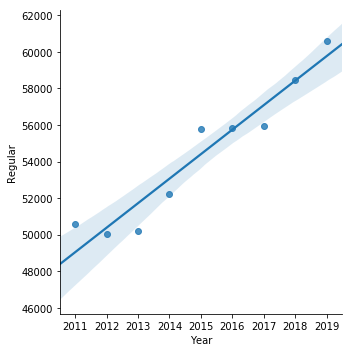

In [23]:
import seaborn as sns

regression_plot = sns.lmplot(x = "Year", y = "Regular", data = yearly_means, fit_reg = True)

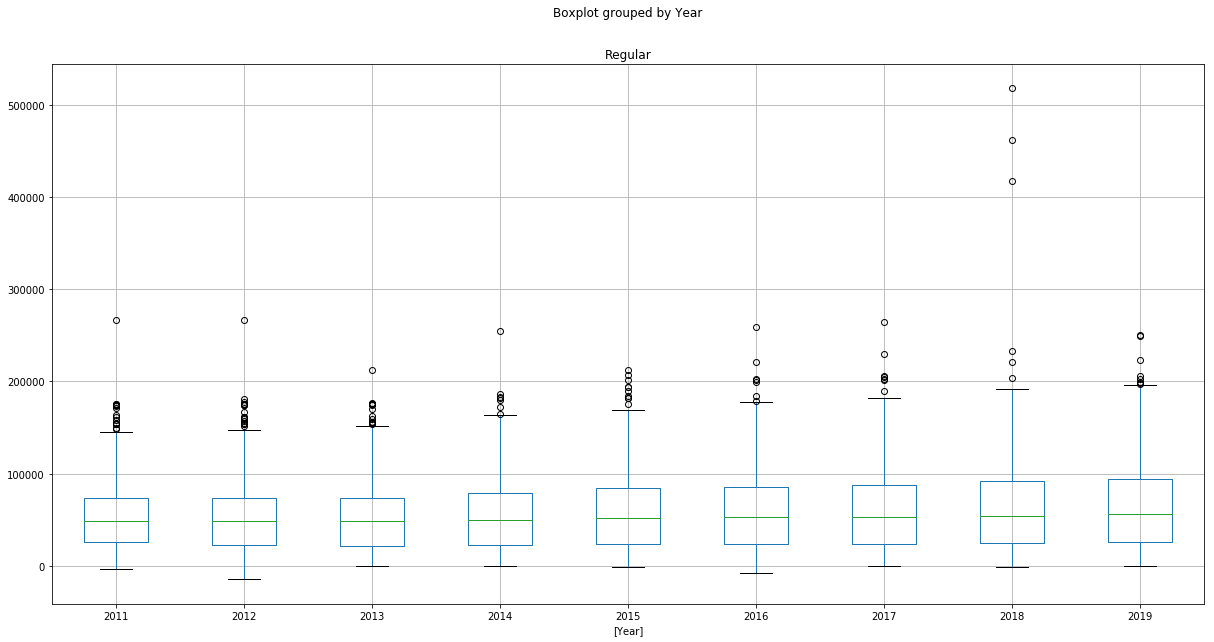

In [24]:
regular_with_year = CUMULATIVE_REPORT[["Regular", "Year"]]
regular_with_year.boxplot(by="Year", figsize=(20, 10))

# 2. Dimension Reduction
## Primary Component Analysis Functions

In [25]:
'''
Name:     getPrincipalColHeadings
Param:    number of principal components
Returns:  an array of strings with format "Principal Component x", where x is a number from 0 to n
'''
def getPrincipalColHeadings(n):
    
    headings = []
    for i in range(n):
        headings.append("Principal Component " + str(i + 1))
        
    return headings

'''
Name:     preprocessPCA
Param:    a dataframe, a list of feature names, a target name
Returns:  a features dataframe (x) and a target dataframe (y)
Does:     separates the target from the features
'''
def preprocessPCA(df, features, targetName):
    
    # Separating out the features
    x = df.loc[:, features].values
    
    # Separating out the target
    y = pd.DataFrame()
    try:
        y = df.loc[:, [targetName]]. values
    except (KeyError):
        print(targetName + " not among columns\nContinuing w/o target values\n")
    
    return x, y

'''
Name:     plotPCA
Param:    number of dimensions, a 2D dataframe, labels for the x and y axis stored (String array), 
          the key value associated with the target variable (String), the set of intervals used to 
          classify the target, and the year (optional)
Returns:  none
Does:     displays an n-D scatterplot of the pca data, color-coded by interval, if n is supported
'''
def plotPCA(n, df, axisLabels, target, year=""):
    
    targetSet, targetColName = setTargetPCA(target)
    
    x_axis = axisLabels[0]
    y_axis = axisLabels[1]
    
    if (n==2):        
        fig = plt.figure(figsize = (8,8))
        ax = fig.add_subplot(1,1,1) 
        ax.set_xlabel(x_axis, fontsize = 15)
        ax.set_ylabel(y_axis, fontsize = 15)
        ax.set_title("2 component PCA\nCity of Boston's " + year + " Employee Earnings Report\n"
                     + "(interval code: " + target + ")", fontsize = 20)

        if (targetColName == ""):
            plt.plot(df.iloc[:, 0], df.iloc[:, 1], 'o', color=COLORS[0]);
        else:
            for t, color in zip(targetSet, COLORS):
                indicesToKeep = df[targetColName] == t
                ax.scatter(df.loc[indicesToKeep, x_axis], df.loc[indicesToKeep, y_axis], c = color, s = 50)

            if (targetColName == "BostonIncomeCat"):    
                ax.legend(LEGEND_BOSTON_INCOME)
            elif (targetColName == "GeneralIncomeCat"):    
                ax.legend(LEGEND_GENERAL_INCOME)
        ax.grid() 
        
    return

def setTargetPCA(target):
    if target in INCOME_TARGETS_DICT:
        return INCOME_TARGETS_DICT[target], TARGET_COLS_DICT[target]
    raise Exception("Target is not supported.\n")
    
def splitFeaturesFrmTarget(df, features, target):
    targetSet, targetColName = setTargetPCA(target)
    
    # Separate the data
    x, y = preprocessPCA(df, features, targetColName)
    
    return x, y 

#### For modeling purposes

In [26]:
def pca_train_test_split(n, df, features, target, test_size=.25, random_state=0):
    
    # Split the features DF (x) from the target DF (y)
    x, y = splitFeaturesFrmTarget(cuRep_copy, features, target)
    
    # Create a traing dataset and a testing dataset; pass in desired test size
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .25, random_state=0)
    
    # Standardize dataset's features on test set, and transform the features of both datasets
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    
    # Apply PCA to the features of the training and testing sets
    pca = PCA(n_components = n)
    pca.fit(x_train)
    x_train = pca.transform(x_train)   # equivalent to principalComponents in runPCA
    x_test = pca.transform(x_test)

    return x_train, y_train, x_test, y_test

#### For non-modeling purposes

In [27]:
'''
Name:     runPCA
Param:    the number of dimensions need, a dataframe, the key value associated with the target variable (String), 
          the year associated with the data (optional) - for cumulative data, enter "Cumulative" for year
Returns:  a primary component dataframe
'''
def runPCA(numDimensions, report, features, target, year=""):
    
    targetSet, targetColName = setTargetPCA(target)
    
    # Separate and standardize the data
    x, y = preprocessPCA(report, features, targetColName)
    
    # Standardizing the features
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    
    pcHeadings = getPrincipalColHeadings(numDimensions)
    
    # PCA Projection to the given number of dimensions
    pca = PCA(n_components = numDimensions)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents, columns = pcHeadings)
    
    # Attach target data to pca dataframe  
    if (targetColName == ""):
        finalDf = pd.concat([principalDf, report[[]]], axis = 1)
    else:
        finalDf = pd.concat([principalDf, report[[targetColName]]], axis = 1)
        
    plotPCA(numDimensions, finalDf, pcHeadings, target, str(year))
    
    print("Explained Variance")
    print(pca.explained_variance_ratio_)
    
    return finalDf    

### pca_train_test_split
#### Use: PCA for modeling purposes 

In [28]:
# Step 1. Assign income interval based on value of TotalEarnings
cuRep_copy = addIncomeCategoryCols(CUMULATIVE_REPORT)

# Step 2. Calling pca_train_test_split will split the DF into training and testing datasets, 
# and reduce the number dimensions 
# Requires that a key (String) be passed in indicating the set of intervals to be used
x_train, y_train, x_test, y_test = pca_train_test_split(2, cuRep_copy, 
                                                        SELECTED_NUMERIC_FEATURES, 
                                                        "BOSTON", 
                                                        test_size = 0.5)

# Step 3. Fit chosen model on x_train, y_train

# Step 4. Have the fitted model predict the target (i.e. y_predict) for x_test

# Step 5. Measure the accuracy of the prediction (y_predict) against the actual (y_test)


### runPCA
#### Use: PCA for viewing *entire* dataset as its primary components

Cumulative Report using generalized income level intervals (increment by 40k)

Explained Variance
[0.25627493 0.14688915]


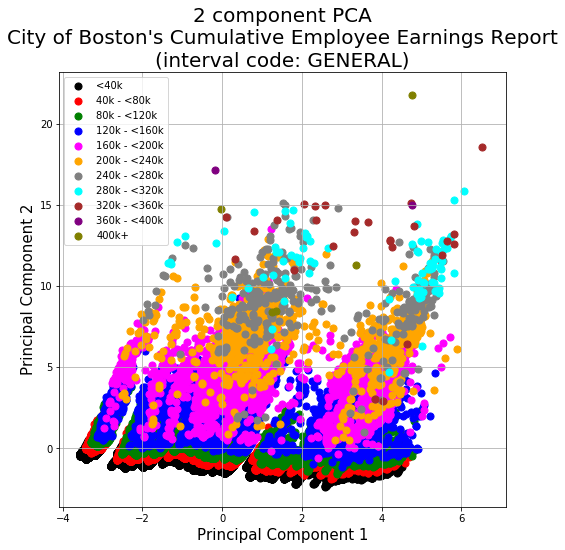

In [29]:
cr_general = addIncomeCategoryCols(CUMULATIVE_REPORT)
pca_df = runPCA(2, cr_general, SELECTED_NUMERIC_FEATURES, "GENERAL", "Cumulative")

# 3. Models

## 3.1. Linear Regression

In [30]:
from sklearn.metrics import r2_score

def linear_regression_model(data, feature1, feature2):
    train, test = train_test_split(data)
    x_train = train[feature1]
    y_train = train[feature2]
    x_test = test[feature1]
    y_test = test[feature2]

    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    x_train = x_train.reshape(-1, 1)
    x_test = x_test.reshape(-1, 1)

    regr = LinearRegression()
    regr.fit(x_train, y_train)
    y_pred = regr.predict(x_test)
    # The coefficient(s).
    print("Coefficient(s): {}".format(regr.coef_))
    # The mean square error.
    print("Residual sum of squares: {:.2f}".format(np.mean(((regr.predict(x_test) - y_test) ** 2))))
    # Explained variance score (1 is perfect prediction).
    print("Variance score: {:.2f}".format(regr.score(x_test, y_test)))
    print("R2 Score: {}".format(r2_score(y_test,y_pred)))

In [31]:
print("Linear Regression model between Regular and OverTime pay:\n")

for y in YEARS:
    print("Year: {}".format(y))
    linear_regression_model(data_by_year[y], "Regular", "Overtime")
    print()

Linear Regression model between Regular and OverTime pay:

Year: 2011
Coefficient(s): [0.08097167]
Residual sum of squares: 59001536.09
Variance score: 0.11
R2 Score: 0.1062098194862654

Year: 2012
Coefficient(s): [0.08517502]
Residual sum of squares: 56669092.56
Variance score: 0.12
R2 Score: 0.11570979913541624

Year: 2013
Coefficient(s): [0.08876267]
Residual sum of squares: 81261239.56
Variance score: 0.10
R2 Score: 0.09542996882554655

Year: 2014
Coefficient(s): [0.10015444]
Residual sum of squares: 86300772.03
Variance score: 0.10
R2 Score: 0.1004078558096454

Year: 2015
Coefficient(s): [0.09895189]
Residual sum of squares: 110393973.12
Variance score: 0.12
R2 Score: 0.11703887384691036

Year: 2016
Coefficient(s): [0.10465994]
Residual sum of squares: 92041280.63
Variance score: 0.12
R2 Score: 0.11929921727381687

Year: 2017
Coefficient(s): [0.11052624]
Residual sum of squares: 113840386.07
Variance score: 0.12
R2 Score: 0.12294547035166348

Year: 2018
Coefficient(s): [0.11569793

## 3.2. K-Means Clustering

In [77]:
kMeans = CUMULATIVE_REPORT.copy()
kMeans = addIncomeCategoryCols(kMeans)

In [79]:
columnNames=["Retroactive", "Other", "Overtime", "Injured", "Detail", "EducationIncentive", "TotalEarnings", "Year"]
kMeans = kMeans.drop(columnNames, axis=1)

In [80]:
kMeans.head()

,Name,Department,Title,Regular,ZIPCode,MedianIncome,pctAsian,pctBlack,pctWhite,pctHispanic,pctMultipleRaces,pctOther,GeneralIncomeCat,BostonIncomeCat
0,"Abadi,Kidani A",Assessing Department,Property Officer (Asn),33065.38,02118,49933.0,14.5426,20.8079,52.1345,19.5976,3.8215,8.6935,0,1
1,"Ackerly,Lyn E.",Boston Public Library,Spec Library Asst I,35058.78,02118,49933.0,14.5426,20.8079,52.1345,19.5976,3.8215,8.6935,0,1
2,"Andersen,Erik K.",Elderly Commission,Sr Budget Anl (Eld/Fiscal),71857.84,02118,49933.0,14.5426,20.8079,52.1345,19.5976,3.8215,8.6935,1,3
3,"Andino,Martin",Boston Cntr - Youth & Families,Streetworkers,36914.95,02118,49933.0,14.5426,20.8079,52.1345,19.5976,3.8215,8.6935,0,1
4,"Boscana,Santos",Inspectional Services Dept,Envrnmntl Health Inspector I,61694.53,02118,49933.0,14.5426,20.8079,52.1345,19.5976,3.8215,8.6935,1,3


[[14571.22787594  2127.90899239]
 [54151.6282811   2129.07644676]
 [96978.53926717  2131.07930074]]


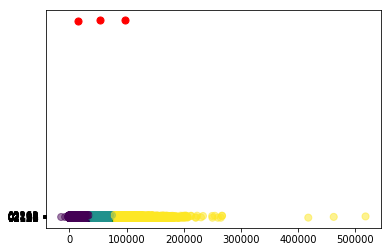

In [83]:
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
  
df = DataFrame(kMeans,columns=['Regular', 'ZIPCode'])
  
kmeans = KMeans(n_clusters=3).fit(df)
centroids = kmeans.cluster_centers_
print(centroids)

plt.scatter(df['Regular'], df['ZIPCode'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

## 3.3 Decision Tree

In [65]:
df = CUMULATIVE_REPORT.copy()

In [66]:
df_PCA_test = addIncomeCategoryCols(df)

In [67]:
df_PCA_test.head()

,Name,Department,Title,Regular,Retroactive,Other,Overtime,Injured,Detail,EducationIncentive,...,Year,MedianIncome,pctAsian,pctBlack,pctWhite,pctHispanic,pctMultipleRaces,pctOther,GeneralIncomeCat,BostonIncomeCat
0,"Abadi,Kidani A",Assessing Department,Property Officer (Asn),33065.38,0.0,0.00,379.49,0.0,0.0,0.0,...,2011,49933.0,14.5426,20.8079,52.1345,19.5976,3.8215,8.6935,0,1
1,"Ackerly,Lyn E.",Boston Public Library,Spec Library Asst I,35058.78,0.0,0.00,439.19,0.0,0.0,0.0,...,2011,49933.0,14.5426,20.8079,52.1345,19.5976,3.8215,8.6935,0,1
2,"Andersen,Erik K.",Elderly Commission,Sr Budget Anl (Eld/Fiscal),71857.84,0.0,1386.83,0.00,0.0,0.0,0.0,...,2011,49933.0,14.5426,20.8079,52.1345,19.5976,3.8215,8.6935,1,3
3,"Andino,Martin",Boston Cntr - Youth & Families,Streetworkers,36914.95,0.0,0.00,261.44,0.0,0.0,0.0,...,2011,49933.0,14.5426,20.8079,52.1345,19.5976,3.8215,8.6935,0,1
4,"Boscana,Santos",Inspectional Services Dept,Envrnmntl Health Inspector I,61694.53,0.0,3137.59,1885.07,0.0,0.0,0.0,...,2011,49933.0,14.5426,20.8079,52.1345,19.5976,3.8215,8.6935,1,3


Explained Variance
[0.25627493 0.14688915]


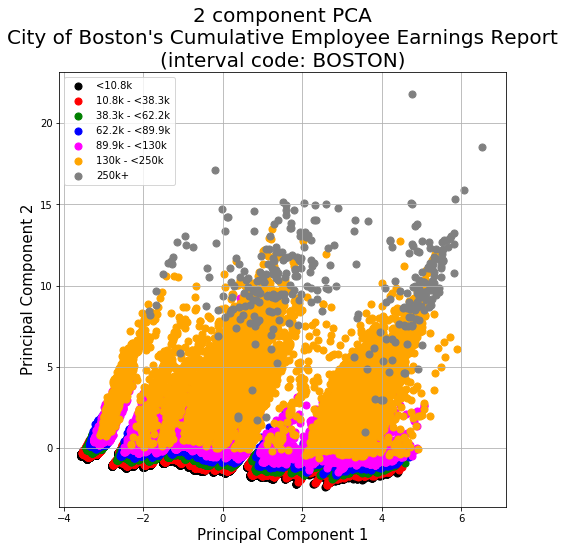

In [68]:
# To Surendra and Zack, from Rebecca:  I think you should include year in the feature set when calling runPCA on
# CUMULATIVE_REPORT in order to catch any significant differences from year to year, so I suggest replacing 
# features_noYr with SELECTED_NUMERIC_FEATURES
out = runPCA(2, df_PCA_test,SELECTED_NUMERIC_FEATURES, "BOSTON", "Cumulative")

In [69]:
out = out.round(2)
out = out.dropna()
out.head()

,Principal Component 1,Principal Component 2,BostonIncomeCat
0,0.17,-1.19,1
1,0.18,-1.16,1
2,0.32,-0.78,3
3,0.19,-1.15,1
4,0.31,-0.72,3


In [70]:
from sklearn import tree

X = out[['Principal Component 1', 'Principal Component 2']].to_numpy()
Y = out[['BostonIncomeCat']].to_numpy()

X_train = X[:230]
Y_train = Y[:230]

X_test = X[230:]
Y_test = Y[230:]

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, Y_train)

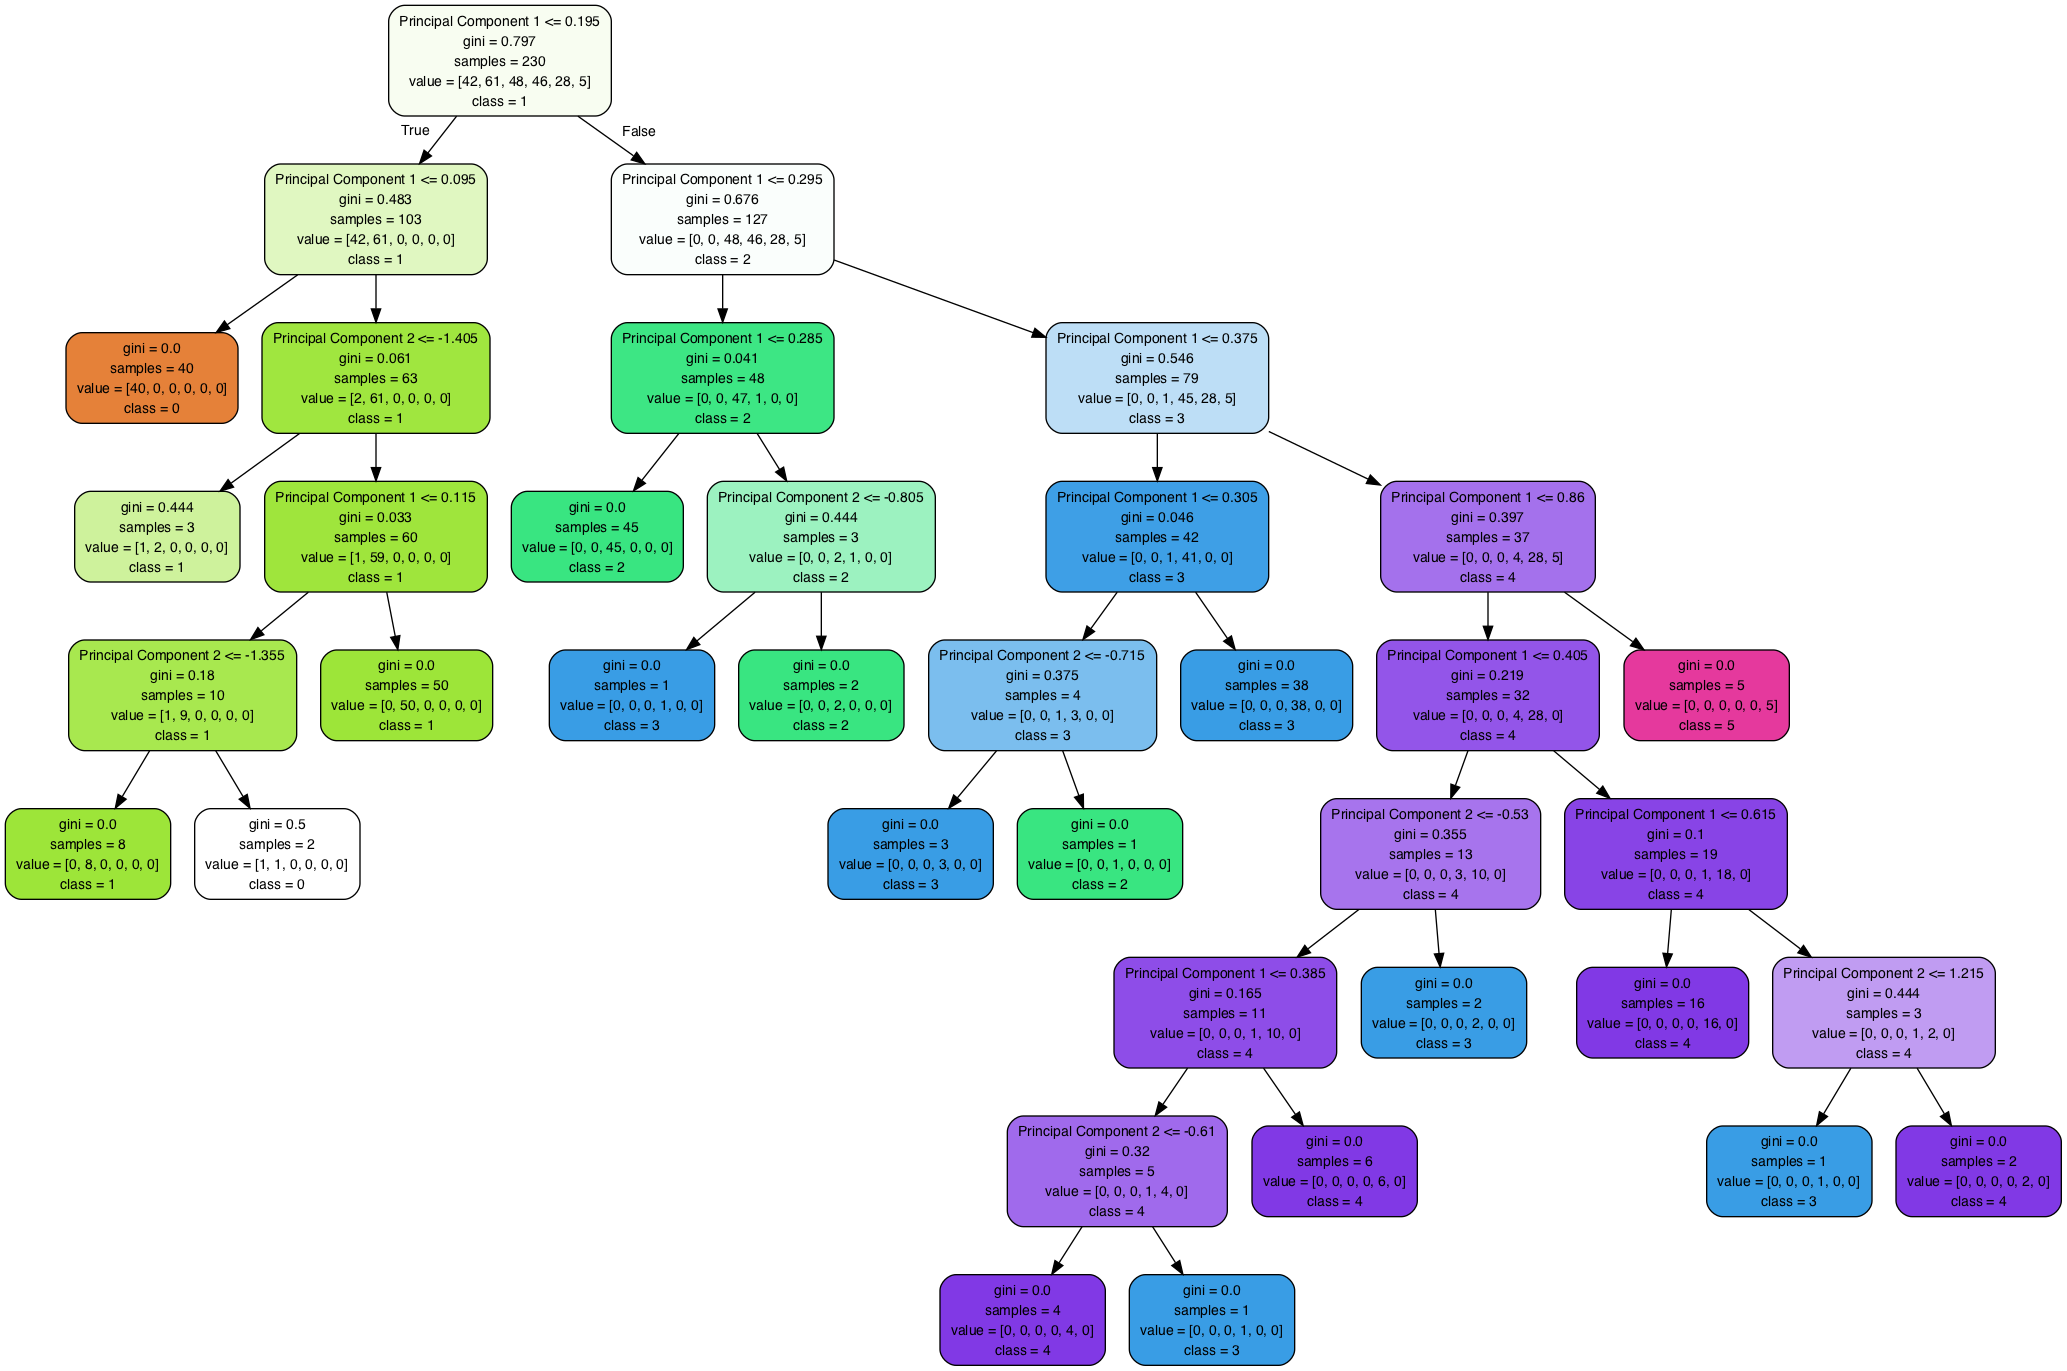

In [71]:
from sklearn.tree import export_graphviz
from IPython.display import Image  
import pydotplus
from sklearn import tree

feature_names = ['Principal Component 1', 'Principal Component 2']
dot_data = tree.export_graphviz(clf,
                                feature_names=feature_names,
                                out_file=None,
                                filled=True,
                                rounded=True,
                                class_names=['0', '1', '2', '3', '4', '5', '6'])
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('Boston_Income_PCA.png')
Image(graph.create_png())

In [72]:
from sklearn import tree

X = out[['Principal Component 1', 'Principal Component 2']].to_numpy()
Y = out[['BostonIncomeCat']].to_numpy()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)

In [73]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, y_pred)*100

72.94418604651163

In [74]:
from sklearn.metrics import classification_report
target_names = ['0', '1', '2', '3', '4', '5', '6']
print(classification_report(Y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      5650
           1       0.79      0.81      0.80      8755
           2       0.70      0.69      0.70      8560
           3       0.59      0.59      0.59      7166
           4       0.72      0.69      0.70      9409
           5       0.72      0.71      0.71      3349
           6       0.57      0.58      0.57       111

    accuracy                           0.73     43000
   macro avg       0.71      0.71      0.71     43000
weighted avg       0.73      0.73      0.73     43000

